In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI,GoogleGenerativeAIEmbeddings
import os
# from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_community.tools.yahoo_finance_news import YahooFinanceNewsTool
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_core.tools import Tool
load_dotenv()
groq_api_key = os.environ["GROQ_API_KEY"]
os.environ["SERPER_API_KEY"]=os.getenv("SERPER_API_KEY")
# llm =ChatGroq(groq_api_key=groq_api_key,model_name="llama-3.2-1b-preview")
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash",google_api_key=os.getenv("GEMINI_API_KEY"))
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001",google_api_key=os.getenv("GEMINI_API_KEY"))
duck = DuckDuckGoSearchResults()
test=GoogleSerperAPIWrapper()
serper =  Tool(
        name="TextRetrieval",
        func=test.run,
        description="useful for when you need to ask with search",
    )
yahoo = YahooFinanceNewsTool()
# wiki = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
tools=[duck,yahoo,serper]

In [31]:
from langgraph.prebuilt import create_react_agent
sys_prompt = "You are a financial research assistant. Your role is to provide a neutral, fact-based analysis of market trends, sectors, and companies based on public data and historical patterns.tyr to mimics the question how a human would search it on Google. first of all you have to create a plane to get answer to the rearch query. then you use tools to answer the question. finally you use the answer to each question to get your final answer."
agent_executor = create_react_agent(llm,tools,state_modifier=sys_prompt) 

In [32]:
agent_executor.invoke({"messages":["Gather information about Reliance Industries Limited, including its financial performance, recent news, and analyst ratings."]})

{'messages': [HumanMessage(content='Gather information about Reliance Industries Limited, including its financial performance, recent news, and analyst ratings.', additional_kwargs={}, response_metadata={}, id='babdd2e6-d697-4f46-b78d-b47c49b9f889'),
  AIMessage(content="Okay, I will gather information about Reliance Industries Limited. Here's my plan:\n\n1.  **Financial Performance:** I will use search to find information on Reliance Industries' financial performance.\n2.  **Recent News:** I will use the `yahoo_finance_news` tool to find recent news articles about Reliance Industries.\n3.  **Analyst Ratings:** I will again use search to find analyst ratings for Reliance Industries.\n4.  **Consolidate Information:** I will combine the information from all sources to provide a comprehensive overview.\n\nNow, let's begin!", additional_kwargs={'function_call': {'name': 'duckduckgo_results_json', 'arguments': '{"query": "Reliance Industries Limited analyst ratings"}'}}, response_metadata={

In [33]:
from typing import TypedDict, List, Annotated
from pydantic import BaseModel, Field
import operator
class State(TypedDict):
    input:str
    plan:List[str]
    past_steps: Annotated[List[str],operator.add]
    response: str
    reason:str

class Plan(BaseModel):
    steps: List[str] = Field(description="List of steps to be executed. In sorted order")

In [34]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
           You are a financial research assistant. Generate a concise list of 4 to 6 detailed, search-style questions to help someone gather all the critical financial and strategic information about a company in order to make an informed investment decision.

            Each question should combine multiple aspects such as:
                Financial data (revenue, profit, cash flow, debt, assets, liabilities)
                Performance trends (growth, historical comparisons)
                Strategic direction (future plans, expansions, innovation)
                Market perception (current news, investor sentiment, leadership updates)

            The goal is to reduce the number of questions while ensuring that each one is rich enough to retrieve all necessary insights.
            If needed, increase the length of the question instead of adding more items to the list. Make sure the questions are efficient and practical for web search or API-based research.
            """ 
        ),
        ("placeholder", "{messages}"),
    ]
)


In [35]:
planner = planner_prompt|llm.with_structured_output(Plan)
response = planner.invoke({"messages":[("user","i should invest in reliance or not?")]}).steps
response

["What are Reliance's recent annual and quarterly revenue, profit, and cash flow figures, and how do these key financial metrics compare to their historical performance over the past 3-5 years?",
 'What are the current market perceptions and investor sentiments towards Reliance, including recent news, analyst ratings, and any significant leadership updates or strategic announcements?',
 "How has Reliance's debt and asset profile evolved, and what are the details of their capital expenditure plans, including any significant investments in new projects, expansions, or technological innovations?",
 "What are Reliance's strategic priorities and future growth plans, particularly concerning their diversification into new sectors or expansion within existing markets, and how do these plans align with current industry trends and competitive landscape?"]

In [36]:
from typing import Union, Literal

# class Response(BaseModel):
#     response: Literal["YES","NO"] = Field(description="provide answer yes or no")
#     reson: str = Field(description="provide your reson for answer")
    
class Act(BaseModel):
    response: Literal["YES","NO"] = Field(description="provide answer yes or no")
    reason: str = Field(description="provide your reson for answer")
    
replanner_prompt = ChatPromptTemplate.from_template(
    """ 
    Using the comprehensive research and data provided about the company, analyze the information and provide a recommendation on whether an investment should be made.

    Question:
    {input}

    Supporting Information:
    {past_steps}
        
    """
)

    
replanner = replanner_prompt | llm.with_structured_output(Act)
llm.with_structured_output(Act)

RunnableBinding(bound=ChatGoogleGenerativeAI(model='models/gemini-2.0-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x0000027AD3709A90>, default_metadata=()), kwargs={'tools': [{'type': 'function', 'function': {'name': 'Act', 'description': '', 'parameters': {'properties': {'response': {'description': 'provide answer yes or no', 'enum': ['YES', 'NO'], 'type': 'string'}, 'reason': {'description': 'provide your reson for answer', 'type': 'string'}}, 'required': ['response', 'reason'], 'type': 'object'}}}], 'ls_structured_output_format': {'kwargs': {'method': 'function_calling'}, 'schema': {'type': 'function', 'function': {'name': 'Act', 'description': '', 'parameters': {'properties': {'response': {'description': 'provide answer yes or no', 'enum': ['YES', 'NO'], 'type': 'string'}, 'reason': {'description': 'provide your reson for answer', 'type': 'string'}}, 'required': ['re

In [37]:
print(response)
replanner.invoke({"input":"i should invest in reliance or not?","plan":response,"past_steps":[('Based on the gathered information, provide a recommendation on whether to invest in Reliance.', "Okay, I understand. To provide a recommendation on whether to invest in Reliance, I need to analyze the information I've gathered about the company. I will look for key factors such as:\n\n*   **Financial Performance:** Revenue, profit margins, debt levels, and growth trends.\n*   **Market Position:** Reliance's standing in its industry, market share, and competitive landscape.\n*   **Growth Opportunities:** Expansion plans, new ventures, and potential for future growth.\n*   **Risk Factors:** Regulatory issues, economic conditions, and company-specific risks.\n*   **Valuation:** How the company's stock price compares to its intrinsic value and peers.\n\nOnce I have a clear understanding of these aspects, I can weigh the pros and cons and provide a recommendation on whether an investment in Reliance is advisable.")],"response":""})

["What are Reliance's recent annual and quarterly revenue, profit, and cash flow figures, and how do these key financial metrics compare to their historical performance over the past 3-5 years?", 'What are the current market perceptions and investor sentiments towards Reliance, including recent news, analyst ratings, and any significant leadership updates or strategic announcements?', "How has Reliance's debt and asset profile evolved, and what are the details of their capital expenditure plans, including any significant investments in new projects, expansions, or technological innovations?", "What are Reliance's strategic priorities and future growth plans, particularly concerning their diversification into new sectors or expansion within existing markets, and how do these plans align with current industry trends and competitive landscape?"]


Act(response='NO', reason='Based on the information provided, I need to analyze the factors like financial performance, market position, growth opportunities, risk factors, and valuation of the company to make a recommendation. However, the information required for this analysis is not available. Therefore, I cannot provide a recommendation on whether to invest in Reliance.')

In [38]:
# from typing import Literal
from langgraph.graph import END
from langgraph.types import Send, Command

class ExecuteStep(TypedDict):
    step:str

def execute_step(state:ExecuteStep):
    print("---EXECUTE---")
    plan = state['step']
    task_formated =f""" 
    for the following plan: {plan}\n\n you are tasked with executing step.Try to give answer in details.
     """
    agent_response = agent_executor.invoke({"messages":[("user",task_formated)]})
    return {"past_steps":[agent_response["messages"][-1].content]}

# execute_step({"plan":response})
def continue_execute_step(state:State)->Command[Literal["execute_step"]]:
    return [Send("execute_step",{"step":t}) for t in state['plan']]

def plan_step(state:State):
    print("---PLAN---")
    plan = planner.invoke({"messages":[("user",state['input'])]})
    return {"plan":plan.steps}

# plan_step({"input":"i should invest in reliance or not?"})

def replan_step(state:State):
    print("---REPLAN---")
    output = replanner.invoke(state)
    # print("OUTPUT---->",output)
    return {"response":output.response,"reason":output.reason}



In [39]:
execute_step({"step":"Collect Reliance Industries' financial statements (balance sheet, income statement, cash flow statement) for the past 5 years."})

---EXECUTE---


{'past_steps': ["Okay, I have gathered some information. To collect Reliance Industries' financial statements (balance sheet, income statement, cash flow statement) for the past 5 years, here's what I've found and how I'll proceed:\n\n1.  **Annual Reports:** I can access Reliance Industries' annual reports through the NSE India website and the company's official website. These reports should contain the required financial statements.\n2.  **Financial Results on BSE:** The Bombay Stock Exchange (BSE) website provides quarterly and annual financial results for Reliance Industries.\n3.  **Trendlyne:** Trendlyne also offers financial statements, including balance sheets, profit and loss statements, and cash flow statements, for Reliance Industries with a 15-year history.\n4.  **Smart-Investing:** Smart-Investing provides financial statement analysis, including key metrics and last 5 years annual financial results.\n\nI will now proceed to find the links to these resources and attempt to ex

In [ ]:
from langchain_google_community import GmailToolkit
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage,AIMessage
from langchain_google_community.gmail.utils import (
    build_resource_service,
    get_gmail_credentials,
)

credentials = get_gmail_credentials(
    token_file="token.json",
    scopes=["https://mail.google.com/"],
    client_secrets_file="credentials.json",
)
example_query = "write an email to pawanraut131@gmail.com  for leave on 23-04-2025 generate subject and body"
api_resource = build_resource_service(credentials=credentials)
toolkit = GmailToolkit(api_resource=api_resource)
mail_tools = toolkit.get_tools()
mail_prompt ="You are a mail writer. write a mail for givin conversation btw user and ai."
mail_agent_executor = create_react_agent(llm, tools=mail_tools)

def send_mail(state:State):
    human_message = state["input"]
    answer = state["response"] + ", " + state["reason"]
    ai_message = AIMessage(content=answer)
    system= """You are a professional email assistant.

    Your task is to use the available tools to Send an email to the address: reciver@gmail.com.

    The content of the email must be based on the conversation between a user and an AI assistant. 
    Generate the subject and body of the email, and then send a email using the appropriate tool.

    Sender's name: [Your Name]

    Conversation:
    User: """ + human_message + """
    AI: """ + answer + """

    Instructions:
    - Analyze the full conversation and determine the user's main request or intent.
    - Create a relevant subject line.
    - Write a clear, concise, and polite email body summarizing the request.
    - Use a professional and friendly tone.
    - Give prope indentation and formatting should be used to make the email easy to read.
    """
    response  = mail_agent_executor.invoke({"messages":[system]})
    print(response)
    print(response['messages'][-1].content)
    for event in response["messages"]:
        event.pretty_print()
    # return response['messages'][-1].content
    
    

In [41]:
# print(send_mail({'input':"i should invest in vedanta or not?","reason":"it is not good company","response":"NO"}))
# mail_agent_executor.invoke({"messages":example_query})

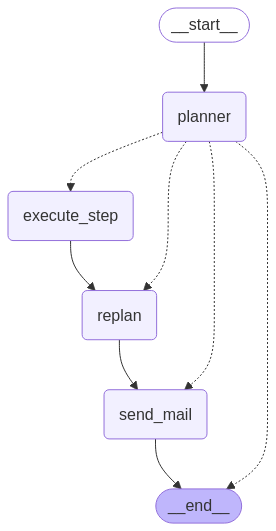

In [42]:
from langgraph.graph import StateGraph, START
from langchain import hub
graph = StateGraph(State)
graph.add_node("planner",plan_step)
graph.add_node("execute_step",execute_step)
graph.add_node("replan",replan_step)
graph.add_node("send_mail",send_mail)
graph.add_edge(START,"planner") 
graph.add_conditional_edges("planner",continue_execute_step) 
graph.add_edge("execute_step","replan") 
graph.add_edge("replan","send_mail")
graph.add_edge("send_mail",END)
app = graph.compile()
app

In [43]:
# app.invoke({"input":"i should invest in reliance or not?"})
for e in app.stream({"input":"i should invest in reliance or not?"}):
    for k, v in e.items():
        if k != "__end__":
            print(f"{k}: {v}")

---PLAN---
planner: {'plan': ["What are Reliance's recent annual and quarterly revenues, net income, and cash flow trends, and how do these figures compare to their historical performance over the past 3-5 years and to their main competitors in the industry?", "What are Reliance's current debt levels, key asset holdings, and liabilities, and how have these changed over the recent years?", "What are Reliance's strategic priorities, including any planned expansions, investments in new technologies, or shifts in business focus, as detailed in their latest investor presentations and annual reports?", "What is the current market sentiment towards Reliance, considering recent news articles, analyst ratings, and major leadership announcements or changes, and how might these factors influence the company's short-term and long-term prospects?"]}
---EXECUTE---
---EXECUTE---
---EXECUTE---
---EXECUTE---


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/RELIANCE%20INDUSTRIES?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=RELIANCE+INDUSTRIES&crumb=2VzjXRMW3PK


execute_step: {'past_steps': ["I am unable to gather specific numerical data regarding Reliance Industries' financials using the available tools. The Yahoo Finance News tool returned an error, and while the DuckDuckGo search provided some press releases about Reliance, Inc. (a different company), it doesn't offer a comprehensive overview of Reliance Industries' financial trends.\n\nTo fully address the request, I would need access to tools that can directly retrieve financial data for Reliance Industries (Reliance Industries ticker symbol is RELIANCE.NS). This would involve accessing financial databases or APIs that provide historical annual and quarterly reports, including revenue, net income, and cash flow figures."]}
execute_step: {'past_steps': ['To determine Reliance\'s strategic priorities, planned expansions, investments in new technologies, and shifts in business focus, I will analyze their latest investor presentations and annual reports.\n\nBased on the search results, I will